In [1]:
import sys
import os
import pandas as pd
import numpy as np
from itertools import product

from sklearn.metrics import root_mean_squared_error

import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

os.environ["KERAS_BACKEND"] = "tensorflow" # 'tensorflow', 'jax´ or 'torch'
import keras
from keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping

if keras.__version__ > "3.0":
    if keras.backend.backend() == "tensorflow":
        import tensorflow
    elif keras.backend.backend() == "torch":
        import torch
    else:
        print("Backend not recognized. Please use 'tensorflow' or 'torch'.")

import skforecast
from skforecast.deep_learning import ForecasterRnn
from skforecast.deep_learning.utils import create_and_compile_model
from sklearn.preprocessing import MinMaxScaler
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster_multiseries

import warnings
warnings.filterwarnings('once')

2024-11-26 01:38:02.232800: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 01:38:07.900443: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 01:38:11.305994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 01:38:17.996366: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 01:38:18.000821: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 01:38:26.159342: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
def load_datasets():
    current_dir = os.getcwd()
    ROOT_PATH = os.path.dirname(current_dir)
    sys.path.insert(1, ROOT_PATH)
    import root

    train = pd.read_pickle(root.DIR_DATA_STAGE + 'train_preprocessed.pkl')
    test = pd.read_pickle(root.DIR_DATA_STAGE + 'test_preprocessed.pkl')
    return root, train, test

In [3]:
def create_model(data_train, levels, lags, steps, recurrent_units, dense_units, learning_rate):
    model = create_and_compile_model(
        series=data_train,
        levels=levels, 
        lags=lags,
        steps=steps,
        recurrent_layer="LSTM",
        recurrent_units=recurrent_units,
        dense_units=dense_units,
        optimizer=Adam(learning_rate=learning_rate), 
        loss=MeanSquaredError()
    )
    return model

In [4]:
def create_forecaster(data_train, data_val, model, levels, steps, lags, epochs, batch_size):
    forecaster = ForecasterRnn(
        regressor=model,
        levels=levels,
        steps=steps,
        lags=lags,
        transformer_series=MinMaxScaler(),
        fit_kwargs={
            "epochs": epochs,             # Número de épocas para entrenar el modelo.
            "batch_size": batch_size,     # Tamaño del batch para entrenar el modelo.
            "series_val": data_val,       # Datos de validación para el entrenamiento del modelo.
        },
    )
    forecaster.fit(data_train)
    return forecaster

In [5]:
def backtesting(data, end_val, forecaster, levels):
    cv = TimeSeriesFold(
        steps=forecaster.max_step,
        initial_train_size=len(data.loc[:end_val, :]),
        refit=False,
    )
    metrics, predictions = backtesting_forecaster_multiseries(
        forecaster=forecaster,
        series=data,
        levels=forecaster.levels,
        cv=cv,
        metric=root_mean_squared_error,
        verbose=False,
    )
    return metrics, predictions

In [6]:
root, train, test = load_datasets()
data = pd.concat([train, test])
end_val = '2022-08-31 23:59:59'
val = train.loc[end_val:]
train = train.loc[:end_val]

In [7]:
series = ['target', 'temperature', 'rain', 'snowfall', 'surface_pressure', 'cloudcover_total', 'windspeed_10m', 'winddirection_10m', 'shortwave_radiation', 'euros_per_mwh', 'installed_capacity'] 
levels = ['target']  # Serie que se quiere predecir
steps = 24           # Pasos a futuro a predecir

data_train = train[series].copy()
data_val = val[series].copy()
data_test = test[series].copy()

In [8]:
param_grid = {
    "lags": [24, 72],
    "recurrent_units": [[100, 50], [128, 64]],
    "dense_units": [[32, 16], [64, 32]],
    "learning_rate": [0.01, 0.001],
    "epochs": [4, 8],
    "batch_size": [64, 128],
}

grid = list(product(*param_grid.values()))
best_metrics = float("inf")
best_params = None
best_forecaster = None
best_predictions = None

In [ ]:
# metrics

Training model 1/64 with params: (24, [100, 50], [32, 16], 0.01, 4, 64)
0.12754838254193665 <class 'numpy.float64'> 0.12754838254193665 <class 'numpy.float64'>
Training model 2/64 with params: (24, [100, 50], [32, 16], 0.01, 4, 128)
0.12754838254193665 <class 'numpy.float64'> 0.12754838254193665 <class 'numpy.float64'>
Training model 3/64 with params: (24, [100, 50], [32, 16], 0.01, 8, 64)
0.12754838254193665 <class 'numpy.float64'> 0.12754838254193665 <class 'numpy.float64'>
Training model 4/64 with params: (24, [100, 50], [32, 16], 0.01, 8, 128)
0.12754838254193665 <class 'numpy.float64'> 0.12754838254193665 <class 'numpy.float64'>
Training model 5/64 with params: (24, [100, 50], [32, 16], 0.001, 4, 64)
0.12754838254193665 <class 'numpy.float64'> 0.12754838254193665 <class 'numpy.float64'>
Training model 6/64 with params: (24, [100, 50], [32, 16], 0.001, 4, 128)
0.12754838254193665 <class 'numpy.float64'> 0.12754838254193665 <class 'numpy.float64'>
Training model 7/64 with params: (2

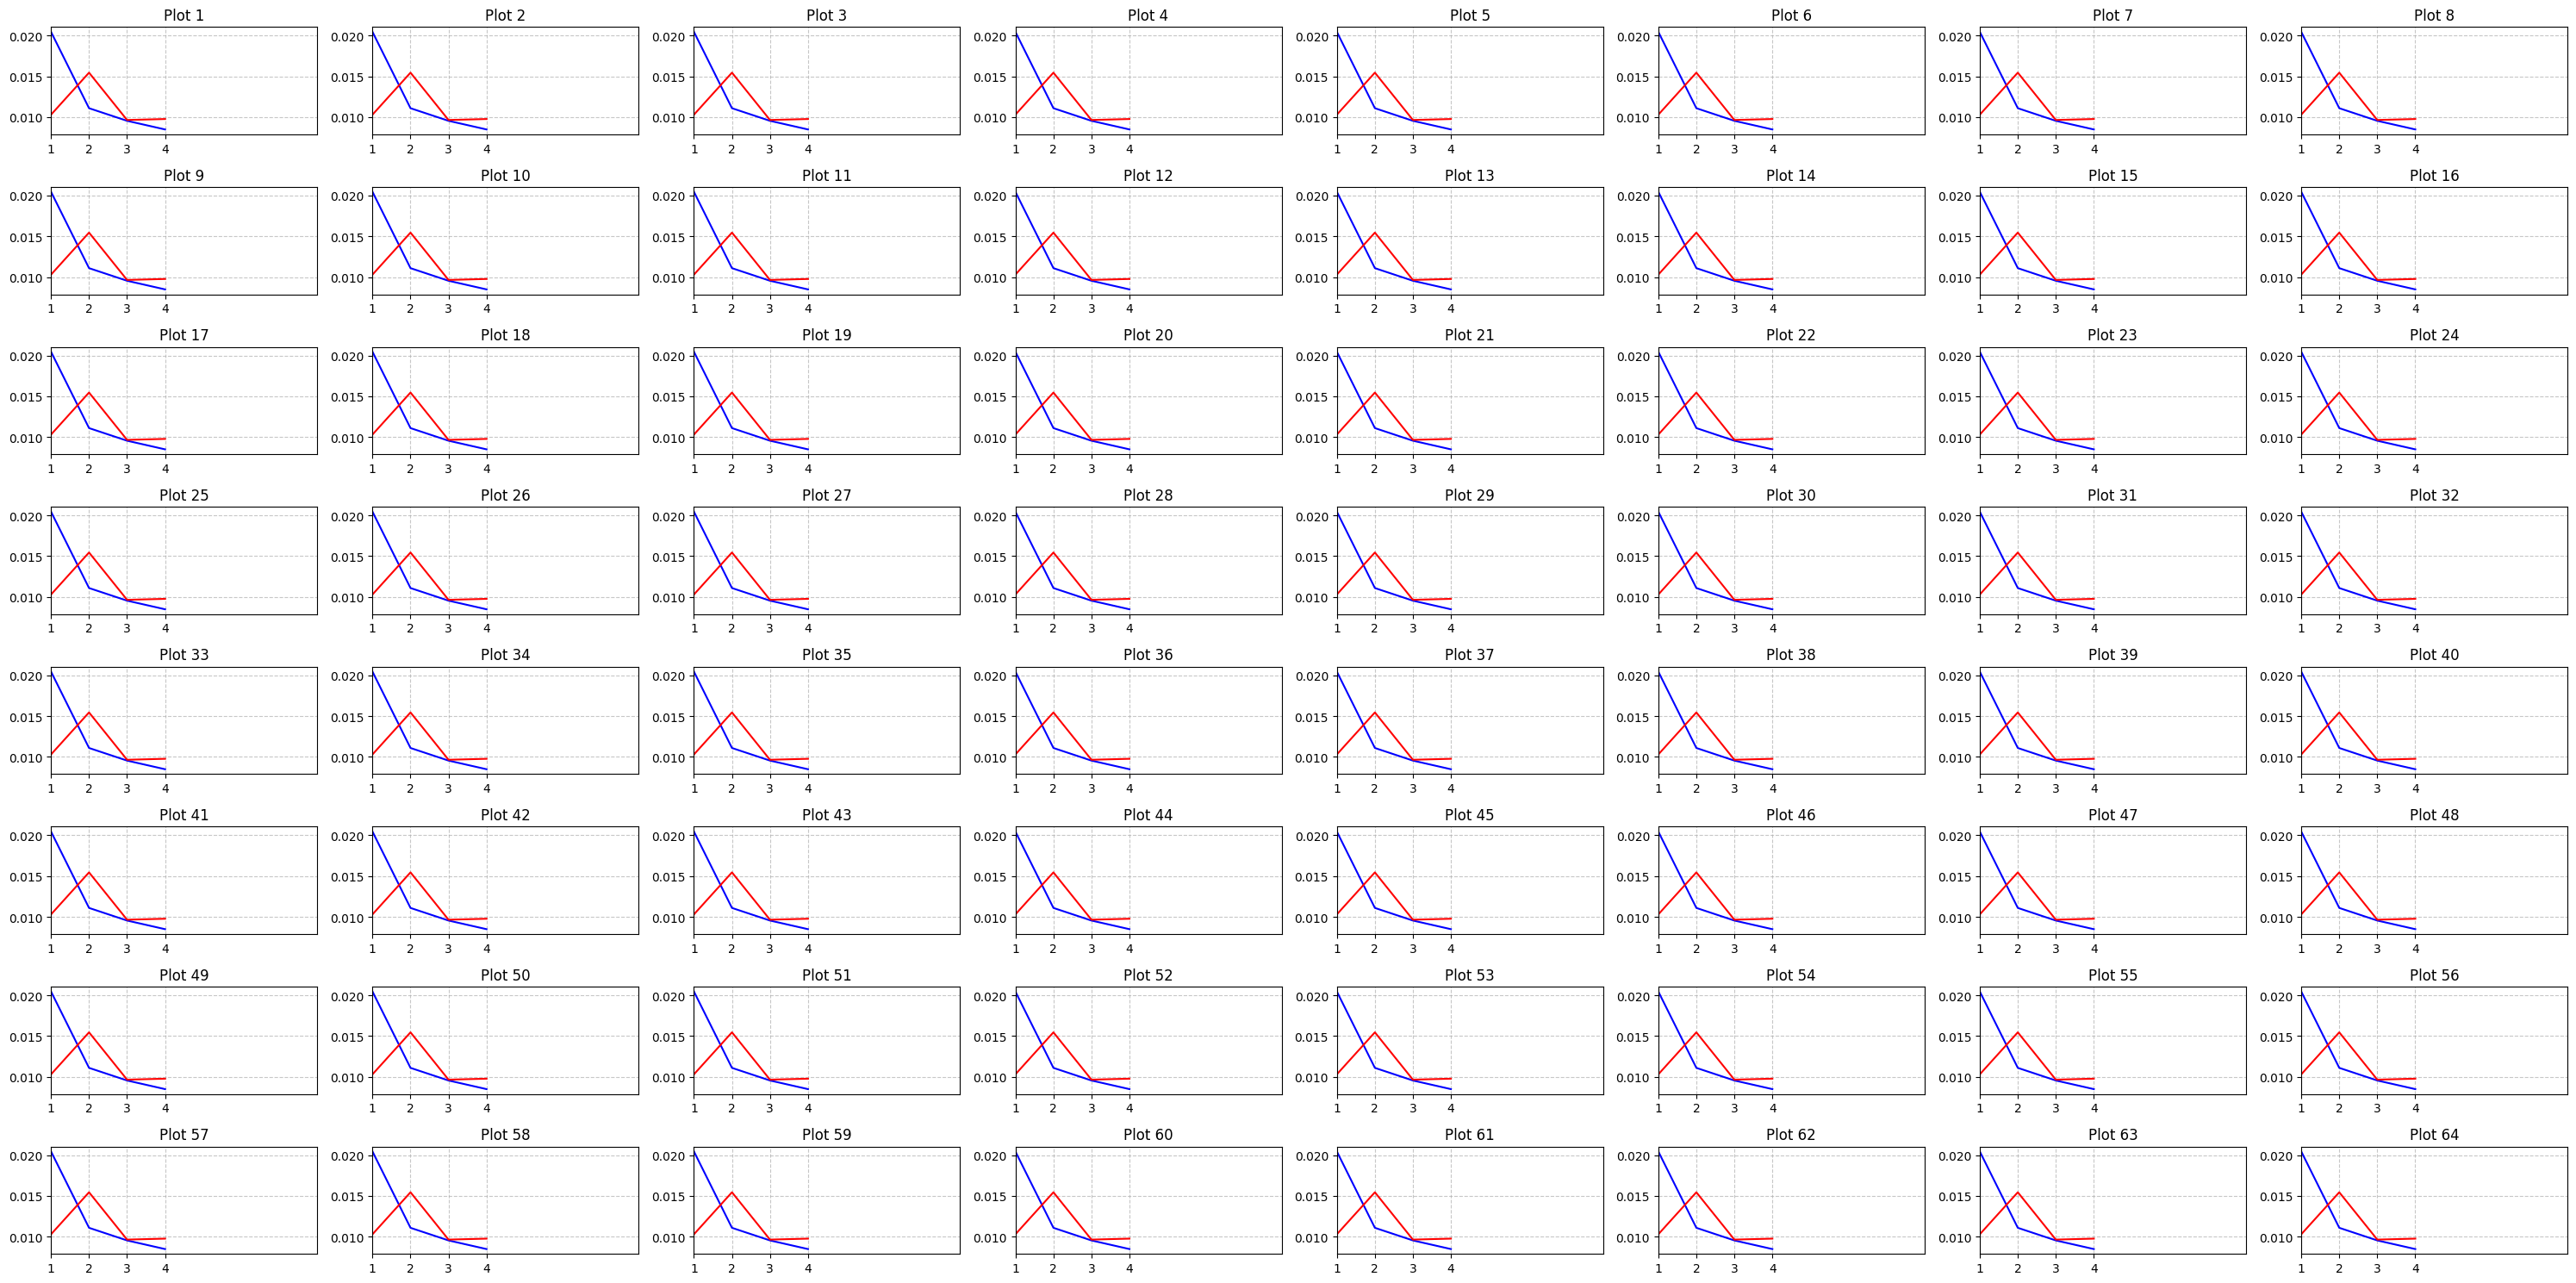

In [ ]:
# Save results
fig, ax = plt.subplots(8, 8, figsize=(30, 15))
ax = ax.flatten()
results = pd.DataFrame({'model': [], 'lags': [], 'recurrent_units': [], 'dense_units': [], 'learning_rate': [], 'epochs': [], 'batch_size': [], 'RMSE': []})

for i, params in enumerate(grid):
    print(f"Training model {i + 1}/{len(grid)} with params: {params}")
    lags, recurrent_units, dense_units, learning_rate, epochs, batch_size = params

    # Create the model
    model = create_model(data_train, levels, lags, steps, recurrent_units, dense_units, learning_rate)

    # Create the forecaster
    forecaster = create_forecaster(data_train, data_val, model, levels, steps, lags, epochs, batch_size)

    # Evaluate performance using backtesting
    metrics, predictions = backtesting(data, end_val, forecaster, levels)

    # Check if this combination is the best so far
    current_metric = metrics.root_mean_squared_error.values[0]
    print(current_metric, type(current_metric), best_metrics, type(best_metrics))
    if current_metric < best_metrics:
        best_metrics = current_metric
        best_params = params
        best_forecaster = forecaster
        best_predictions = predictions
        print(f"New best model found with RMSE: {current_metric}")
    
    # Save results
    forecaster.plot_history(ax=ax[i])
    ax[i].set_xlim(1, 8)
    ax[i].set_title(f"Plot {i+1}")
    ax[i].set_xlabel('')
    ax[i].set_ylabel('')
    ax[i].legend().remove()

    new_row = pd.DataFrame([{'model': i+1, 'lags': lags, 'recurrent_units': recurrent_units, 'dense_units': dense_units, 'learning_rate': learning_rate, 'epochs': epochs, 'batch_size': batch_size, 'RMSE': current_metric}])
    results = pd.concat([results, new_row], ignore_index=True)

print(f"\nBest hyperparameters: {best_params}")
print(f"Best validation RMSE: {best_metrics}")
results.to_excel(root.DIR_DATA_ANALYTICS + 'LSTM_grid_search_results.xlsx', index=False)
plt.tight_layout()
fig.savefig(root.DIR_DATA_ANALYTICS + 'LSTM_grid_search_plots.png', dpi=300)
plt.show()